# Seqeunce Model with Attention for Automatic Date Conversion

- Use seq-to-seq model to learn date conversion
- This is based on Chapter 8 of [Deep Learning 2: 用 Python 進行自然語言處理的基礎理論實作](https://www.tenlong.com.tw/products/9789865020675).
- This notebook uses two types of Attention layers:
  - The first type is the default `keras.layers.Attention` (Luong attention) and `keras.layers.AdditiveAttention` (Bahdanau attention). (But these layers have ONLY been implemented in Tensorflow-nightly.
  - The second type is developed by Thushan.
    - Bahdanau Attention Layber developed in [Thushan](https://github.com/thushv89/attention_keras)
    - Thushan Ganegedara's
    [Attention in Deep Networks with Keras](https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39)

- This notebook runs on Google Colab (It installs the nightly version of the Tensorflow becuase of the new implementation of Attention layers).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive/_MySyncDrive/Repository/python-notes/nlp')

In [3]:
%pwd

'/content/drive/My Drive/_MySyncDrive/Repository/python-notes/nlp'

In [4]:
!pip install tf-nightly

In [5]:
import tensorflow, keras
print(tensorflow.__version__)
print(keras.__version__)

2.5.0-dev20201103
2.4.3


## Functions

### Data Preparation

In [6]:
import re
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Dense, GRU, Bidirectional
from tensorflow.keras.layers import AdditiveAttention, Attention
import numpy as np
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras import Model
from keras.models import Sequential
from keras.layers import LSTM, GRU, Concatenate
from keras.layers import Attention
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras import Input
from attention import AttentionLayer
from keras.utils import to_categorical, plot_model


# Path to the data txt file on disk.
def get_data(data_path, train_test = 0.9):
    #data_path = '../../../RepositoryData/data/deep-learning-2/addition.txt'
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')

    enc_text=[l.split('_')[0] for l in lines]
    dec_text=[l.split('_')[-1].strip() for l in lines]

    dec_text = ['_' + sent + '_' for sent in dec_text]
    
    np.random.seed(123)
    inds = np.arange(len(enc_text))
    np.random.shuffle(inds)
        
    train_size = int(round(len(lines)*train_test))
    train_inds = inds[:train_size]
    test_inds = inds[train_size:]
    tr_enc_text = [enc_text[ti] for ti in train_inds]
    tr_dec_text = [dec_text[ti] for ti in train_inds]

    ts_enc_text = [enc_text[ti] for ti in test_inds]
    ts_dec_text = [dec_text[ti] for ti in test_inds]
    
    return tr_enc_text, tr_dec_text, ts_enc_text, ts_dec_text


## when the max_len is known, use this func to convert text to seq
def sents2sequences(tokenizer, sentences, reverse=False, pad_length=None, padding_type='post'):
    encoded_text = tokenizer.texts_to_sequences(sentences)
    preproc_text = pad_sequences(encoded_text, padding=padding_type, maxlen=pad_length)
    if reverse:
        preproc_text = np.flip(preproc_text, axis=1)
    return preproc_text



def preprocess_data(enc_tokenizer, dec_tokenizer, enc_text, dec_text):
    enc_seq = enc_tokenizer.texts_to_sequences(tr_enc_text)
    enc_timesteps = np.max([len(l) for l in enc_seq])
    enc_seq = pad_sequences(enc_seq, padding='pre', maxlen = enc_timesteps)
    dec_seq = dec_tokenizer.texts_to_sequences(tr_dec_text)
    dec_timesteps = np.max([len(l) for l in dec_seq])
    dec_seq = pad_sequences(dec_seq, padding='post', maxlen = dec_timesteps)
    return enc_seq, dec_seq

### Model Definition: Simple Seq-to-Seq (LSTM)

In [7]:
def define_seq2seq_lstm(hidden_size, batch_size, enc_timesteps, enc_vsize, dec_timesteps, dec_vsize):
    """ Defining a seq2seq model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, dec_timesteps - 1, dec_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(enc_timesteps, enc_vsize), name='encoder_inputs')
        if fr_timesteps:
            decoder_inputs = Input(shape=(dec_timesteps - 1, dec_vsize), name='decoder_inputs')
        else:
            decoder_inputs = Input(shape=(None, dec_vsize), name='decoder_inputs')

    # Encoder LSTM
    encoder_lstm = LSTM(hidden_size, return_sequences=False, return_state=True, name='encoder_lstm')
    encoder_out, encoder_h, encoder_c = encoder_lstm(encoder_inputs) # when `return_sequences=False`, the return output and state are the same
    encoder_states = [encoder_h, encoder_c]
    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_out, decoder_h, decoder_c = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # Dense layer
    dense = Dense(dec_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    # decoder_pred = dense_time(decoder_concat_input)
    decoder_pred = dense_time(decoder_out)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    full_model.summary()
    

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_h, encoder_inf_c = encoder_lstm(encoder_inf_inputs)
    encoder_inf_states = [encoder_inf_h, encoder_inf_c]
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=encoder_inf_states)
          ## This simple seq2seq model would use only the encoder last-timestep output

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, dec_vsize), name='decoder_word_inputs')

    decoder_inf_init_input_h = Input(shape=(hidden_size,))
    decoder_inf_init_input_c = Input(shape=(hidden_size ,))
    decoder_inf_init_state = [decoder_inf_init_input_h, decoder_inf_init_input_c]

    decoder_inf_out, decoder_inf_f, decoder_inf_c = decoder_lstm(decoder_inf_inputs, initial_state=decoder_inf_init_state)


    # decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_out)
    decoder_model = Model(inputs=[decoder_inf_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred])

    return full_model , encoder_model, decoder_model


def train_seq2seq_lstm(full_model, enc_seq, dec_seq, batch_size, n_epochs):
    """ Training the model """
    loss_epoch = []
    accuracy_epoch = []
    for ep in range(n_epochs):
        losses = []
        accuracies = []
        for bi in range(0, enc_seq.shape[0] - batch_size, batch_size):

            enc_onehot_seq = to_categorical(
                enc_seq[bi:bi + batch_size, :], num_classes=enc_vsize)
            dec_onehot_seq = to_categorical(
                dec_seq[bi:bi + batch_size, :], num_classes=dec_vsize)

            full_model.train_on_batch(
                [enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :])

            l,a = full_model.evaluate([enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :],
                                    batch_size=batch_size, verbose=0)

            losses.append(l)
            accuracies.append(a)
        if (ep + 1) % 1 == 0:
            print("Loss/Accuracy in epoch {}: {}/{}".format(ep + 1, np.mean(losses), np.mean(accuracies)))
            loss_epoch.append(np.mean(losses))
            accuracy_epoch.append(np.mean(accuracies))
    return loss_epoch, accuracy_epoch

# def infer_seq2seq_lstm(encoder_model, decoder_model, test_enc_seq, enc_vsize, dec_vsize, dec_timesteps):
#     """
#     Infer logic
#     :param encoder_model: keras.Model
#     :param decoder_model: keras.Model
#     :param test_en_seq: sequence of word ids
#     :param en_vsize: int
#     :param fr_vsize: int
#     :return:
#     """

#     test_dec_seq = sents2sequences(dec_tokenizer, ['_'], dec_vsize)
#     test_enc_onehot_seq = to_categorical(test_enc_seq, num_classes=enc_vsize)
#     test_dec_onehot_seq = np.expand_dims(
#         to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

#     enc_last_state = encoder_model.predict(test_enc_onehot_seq)
#     dec_state = enc_last_state
#     attention_weights = []
#     dec_text = ''
#     for i in range(dec_timesteps):

#         dec_out = decoder_model.predict(
#             [dec_state, test_dec_onehot_seq])
#         dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

#         if dec_ind == 0:
#             break
#         test_dec_seq = sents2sequences(
#             dec_tokenizer, [dec_index2word[dec_ind]], dec_vsize)
#         test_dec_onehot_seq = np.expand_dims(
#             to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

#         attention_weights.append((dec_ind, attention))
#         dec_text += dec_index2word[dec_ind]

#     return dec_text


### Model Definition: Simple Seq-to-seq (GRU)

In [8]:
def define_seq2seq(hidden_size, batch_size, enc_timesteps, enc_vsize, dec_timesteps, dec_vsize):
    """ Defining a seq2seq model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, dec_timesteps - 1, dec_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(enc_timesteps, enc_vsize), name='encoder_inputs')
        if fr_timesteps:
            decoder_inputs = Input(shape=(dec_timesteps - 1, dec_vsize), name='decoder_inputs')
        else:
            decoder_inputs = Input(shape=(None, dec_vsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = GRU(hidden_size, return_sequences=False, return_state=True, name='encoder_gru')
    encoder_out, encoder_state = encoder_gru(encoder_inputs) # when `return_sequences=False`, the return output and state are the same

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

    # # Attention layer
    # # attn_layer = AttentionLayer(name='attention_layer')
    # attn_layer = AdditiveAttention(name="attention_layer")

    # ## The input for AdditiveAttention: query, key
    # ## It returns a tensor of shape as query
    # ## This is different from the AttentionLayer developed by Thushan
    # # attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # attn_out, attn_states  = attn_layer([decoder_out,encoder_out],return_attention_scores=True)

    # Concat attention input and decoder GRU output
    # decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])


    # Dense layer
    dense = Dense(dec_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    # decoder_pred = dense_time(decoder_concat_input)
    decoder_pred = dense_time(decoder_out)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_state = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=encoder_inf_state)
          ## This simple seq2seq model would use only the encoder last-timestep output

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, dec_vsize), name='decoder_word_inputs')
    #encoder_inf_states = Input(batch_shape=(batch_size, enc_timesteps, hidden_size), name='encoder_inf_states')
    decoder_init_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_init')

    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    # attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    # attn_inf_out, attn_inf_states  = attn_layer([decoder_inf_out, encoder_inf_states],return_attention_scores=True)

    # decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_out)
    decoder_model = Model(inputs=[decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred])

    return full_model, encoder_model, decoder_model


def train_seq2seq(full_model, enc_seq, dec_seq, batch_size, n_epochs):
    """ Training the model """
    loss_epoch = []
    accuracy_epoch = []
    for ep in range(n_epochs):
        losses = []
        accuracies = []
        for bi in range(0, enc_seq.shape[0] - batch_size, batch_size):

            enc_onehot_seq = to_categorical(
                enc_seq[bi:bi + batch_size, :], num_classes=enc_vsize)
            dec_onehot_seq = to_categorical(
                dec_seq[bi:bi + batch_size, :], num_classes=dec_vsize)

            full_model.train_on_batch(
                [enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :])

            l,a = full_model.evaluate([enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :],
                                    batch_size=batch_size, verbose=0)

            losses.append(l)
            accuracies.append(a)
        if (ep + 1) % 1 == 0:
            print("Loss/Accuracy in epoch {}: {}/{}".format(ep + 1, np.mean(losses), np.mean(accuracies)))
            loss_epoch.append(np.mean(losses))
            accuracy_epoch.append(np.mean(accuracies))
    return loss_epoch, accuracy_epoch

def infer_seq2seq(encoder_model, decoder_model, test_enc_seq, enc_vsize, dec_vsize, dec_timesteps):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """

    test_dec_seq = sents2sequences(dec_tokenizer, ['_'], dec_vsize)
    test_enc_onehot_seq = to_categorical(test_enc_seq, num_classes=enc_vsize)
    test_dec_onehot_seq = np.expand_dims(
        to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

    enc_last_state = encoder_model.predict(test_enc_onehot_seq)
    dec_state = enc_last_state
    attention_weights = []
    dec_text = ''
    for i in range(dec_timesteps):

        dec_out = decoder_model.predict(
            [dec_state, test_dec_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_dec_seq = sents2sequences(
            dec_tokenizer, [dec_index2word[dec_ind]], dec_vsize)
        test_dec_onehot_seq = np.expand_dims(
            to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

        attention_weights.append((dec_ind, attention))
        dec_text += dec_index2word[dec_ind]

    return dec_text


### Model Definition: Birectional Seq-to-Seq

In [9]:
def define_biseq2seq(hidden_size, batch_size, enc_timesteps, enc_vsize, dec_timesteps, dec_vsize):
    """ Defining a seq2seq model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, dec_timesteps - 1, dec_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(enc_timesteps, enc_vsize), name='encoder_inputs')
        if fr_timesteps:
            decoder_inputs = Input(shape=(dec_timesteps - 1, dec_vsize), name='decoder_inputs')
        else:
            decoder_inputs = Input(shape=(None, dec_vsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = Bidirectional(GRU(hidden_size, return_sequences=False, return_state=True, name='encoder_gru'))
    encoder_out,encoder_fwd_state,encoder_bwd_state = encoder_gru(encoder_inputs) # when `return_sequences=False`, the return output and state are the same

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size*2, return_sequences=True, return_state=True, name='decoder_gru')
      ## *2 because encoder output two sets of output states (forward and backward)
    decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=Concatenate(axis=-1)([encoder_fwd_state, encoder_bwd_state]))

    # # Attention layer
    # # attn_layer = AttentionLayer(name='attention_layer')
    # attn_layer = AdditiveAttention(name="attention_layer")

    # ## The input for AdditiveAttention: query, key
    # ## It returns a tensor of shape as query
    # ## This is different from the AttentionLayer developed by Thushan
    # # attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # attn_out, attn_states  = attn_layer([decoder_out,encoder_out],return_attention_scores=True)

    # Concat attention input and decoder GRU output
    # decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])


    # Dense layer
    dense = Dense(dec_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    # decoder_pred = dense_time(decoder_concat_input)
    decoder_pred = dense_time(decoder_out)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_fwd_state, encoder_inf_bwd_state = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_fwd_state, encoder_inf_bwd_state])
          ## This simple seq2seq model would use only the encoder last-timestep output

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, dec_vsize), name='decoder_word_inputs')
    #encoder_inf_states = Input(batch_shape=(batch_size, enc_timesteps, hidden_size), name='encoder_inf_states')
    decoder_init_state = Input(batch_shape=(batch_size, 2*hidden_size), name='decoder_init') ## forward + backward output states

    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    # attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    # attn_inf_out, attn_inf_states  = attn_layer([decoder_inf_out, encoder_inf_states],return_attention_scores=True)

    # decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_out)
    decoder_model = Model(inputs=[decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred])

    return full_model, encoder_model, decoder_model


def train_biseq2seq(full_model, enc_seq, dec_seq, batch_size, n_epochs):
    """ Training the model """
    loss_epoch = []
    accuracy_epoch = []
    for ep in range(n_epochs):
        losses = []
        accuracies = []
        for bi in range(0, enc_seq.shape[0] - batch_size, batch_size):

            enc_onehot_seq = to_categorical(
                enc_seq[bi:bi + batch_size, :], num_classes=enc_vsize)
            dec_onehot_seq = to_categorical(
                dec_seq[bi:bi + batch_size, :], num_classes=dec_vsize)

            full_model.train_on_batch(
                [enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :])

            l,a = full_model.evaluate([enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :],
                                    batch_size=batch_size, verbose=0)

            losses.append(l)
            accuracies.append(a)
        if (ep + 1) % 1 == 0:
            print("Loss/Accuracy in epoch {}: {}/{}".format(ep + 1, np.mean(losses), np.mean(accuracies)))
            loss_epoch.append(np.mean(losses))
            accuracy_epoch.append(np.mean(accuracies))
    return loss_epoch, accuracy_epoch

def infer_biseq2seq(encoder_model, decoder_model, test_enc_seq, enc_vsize, dec_vsize, dec_timesteps):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """

    test_dec_seq = sents2sequences(dec_tokenizer, ['_'], dec_vsize)
    test_enc_onehot_seq = to_categorical(test_enc_seq, num_classes=enc_vsize)
    test_dec_onehot_seq = np.expand_dims(
        to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

    enc_last_fwd_state, enc_last_bwd_state = encoder_model.predict(test_enc_onehot_seq)
    dec_state = Concatenate(axis=-1)([enc_last_fwd_state, enc_last_bwd_state])
    # attention_weights = []
    dec_text = ''
    for i in range(dec_timesteps):

        dec_out = decoder_model.predict(
            [dec_state, test_dec_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_dec_seq = sents2sequences(
            dec_tokenizer, [dec_index2word[dec_ind]], dec_vsize)
        test_dec_onehot_seq = np.expand_dims(
            to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

        # attention_weights.append((dec_ind, attention))
        dec_text += dec_index2word[dec_ind]

    return dec_text


### Model Definition: Peeky Bidirectional Seq-to-Seq

- Codes do not work yet. Don't know how to add encoder output states to every time step in the decoder.

In [10]:
# def define_peekybiseq2seq(hidden_size, batch_size, enc_timesteps, enc_vsize, dec_timesteps, dec_vsize):
#     """ Defining a seq2seq model """

#     # Define an input sequence and process it.
#     if batch_size:
#         encoder_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inputs')
#         decoder_inputs = Input(batch_shape=(batch_size, dec_timesteps - 1, dec_vsize), name='decoder_inputs')
#     else:
#         encoder_inputs = Input(shape=(enc_timesteps, enc_vsize), name='encoder_inputs')
#         if fr_timesteps:
#             decoder_inputs = Input(shape=(dec_timesteps - 1, dec_vsize), name='decoder_inputs')
#         else:
#             decoder_inputs = Input(shape=(None, dec_vsize), name='decoder_inputs')

#     # Encoder GRU
#     encoder_gru = Bidirectional(GRU(hidden_size, return_sequences=False, return_state=True, name='encoder_gru'))
#     encoder_out, encoder_fwd_state, encoder_bwd_state = encoder_gru(encoder_inputs) # when `return_sequences=False`, the return output and state are the same

#     encoder_concat_states = Concatenate(axis=1)([encoder_fwd_state, encoder_bwd_state])

#     # Concatenate encoder_concat_states with decode_inputs
    
#     decoder_inputs_concat = Concatenate(axis=1)([decoder_inputs, encoder_concat_states])

#     # Set up the decoder GRU, using `encoder_states` as initial state.
#     decoder_gru = GRU(hidden_size*2+dec_vsize, return_sequences=True, return_state=True, name='decoder_gru')
#       ## *2 because encoder output two sets of output states (forward and backward)

#     decoder_init_concat = Concatenate(axis=-1)([np.random.randn(dec_vsize), encoder_fwd_state, encoder_bwd_state])
#     # decoder_init_concat = np.repeat(deconder_init_concat, dec_timesteps, axis=0).reshape(dec_timesteps, dec_vsize+2*hidden_size)

#     decoder_out, decoder_state = decoder_gru(decoder_inputs_concat, initial_state=decoder_init_concat)

#     # Concat attention input and decoder GRU output

#     # Dense layer
#     dense = Dense(dec_vsize, activation='softmax', name='softmax_layer')
#     dense_time = TimeDistributed(dense, name='time_distributed_layer')

#     ### In peeky, when decoding, make use of decoder_out as well as the original encoder_fwd_state and encoder_bwd_state
#     decoder_pred = dense_time(decoder_out)

#     # Full model
#     full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
#     full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     full_model.summary()

#     """ Inference model """
#     batch_size = 1

#     """ Encoder (Inference) model """
#     encoder_inf_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inf_inputs')
#     encoder_inf_out, encoder_inf_fwd_state, encoder_inf_bwd_state = encoder_gru(encoder_inf_inputs)
#     encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_fwd_state, encoder_inf_bwd_state])
#           ## This simple seq2seq model would use only the encoder last-timestep output

#     """ Decoder (Inference) model """
#     decoder_inf_inputs = Input(batch_shape=(batch_size, 1, dec_vsize+2*hidden_size), name='decoder_word_inputs')
#     decoder_init_state = Input(batch_shape=(batch_size, dec_vsize+2*hidden_size), name='decoder_init') ## forward + backward output states

#     decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
  
#     decoder_inf_pred = TimeDistributed(dense)(decoder_inf_out) # decoding with out decoder_inf_out, and decoder_init_state `initial states`
#     decoder_model = Model(inputs=[decoder_init_state, decoder_inf_inputs],
#                           outputs=[decoder_inf_pred])

#     return full_model, encoder_model, decoder_model


# def train_peekybiseq2seq(full_model, enc_seq, dec_seq, batch_size, n_epochs):
#     """ Training the model """
#     loss_epoch = []
#     accuracy_epoch = []
#     for ep in range(n_epochs):
#         losses = []
#         accuracies = []
#         for bi in range(0, enc_seq.shape[0] - batch_size, batch_size):

#             enc_onehot_seq = to_categorical(
#                 enc_seq[bi:bi + batch_size, :], num_classes=enc_vsize)
#             dec_onehot_seq = to_categorical(
#                 dec_seq[bi:bi + batch_size, :], num_classes=dec_vsize)

#             full_model.train_on_batch(
#                 [enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :])

#             l,a = full_model.evaluate([enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :],
#                                     batch_size=batch_size, verbose=0)

#             losses.append(l)
#             accuracies.append(a)
#         if (ep + 1) % 1 == 0:
#             print("Loss/Accuracy in epoch {}: {}/{}".format(ep + 1, np.mean(losses), np.mean(accuracies)))
#             loss_epoch.append(np.mean(losses))
#             accuracy_epoch.append(np.mean(accuracies))
#     return loss_epoch, accuracy_epoch

# def infer_peekybiseq2seq(encoder_model, decoder_model, test_enc_seq, enc_vsize, dec_vsize, dec_timesteps):
#     """
#     Infer logic
#     :param encoder_model: keras.Model
#     :param decoder_model: keras.Model
#     :param test_en_seq: sequence of word ids
#     :param en_vsize: int
#     :param fr_vsize: int
#     :return:
#     """

#     test_dec_seq = sents2sequences(dec_tokenizer, ['_'], dec_vsize)
#     test_enc_onehot_seq = to_categorical(test_enc_seq, num_classes=enc_vsize)
#     test_dec_onehot_seq = np.expand_dims(
#         to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

#     enc_last_fwd_state, enc_last_bwd_state = encoder_model.predict(test_enc_onehot_seq)
#     dec_state = Concatenate(axis=-1)([enc_last_fwd_state, enc_last_bwd_state])
#     # attention_weights = []
#     dec_text = ''
#     for i in range(dec_timesteps):

#         dec_out = decoder_model.predict(
#             [dec_state, test_dec_onehot_seq])
#         dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

#         if dec_ind == 0:
#             break
#         test_dec_seq = sents2sequences(
#             dec_tokenizer, [dec_index2word[dec_ind]], dec_vsize)
#         test_dec_onehot_seq = np.expand_dims(
#             to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

#         # attention_weights.append((dec_ind, attention))
#         dec_text += dec_index2word[dec_ind]

#     return dec_text


### Model Definition: Seq-to-seq with Attention

In [11]:
def define_nmt(hidden_size, batch_size, enc_timesteps, enc_vsize, dec_timesteps, dec_vsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inputs')
        decoder_inputs = Input(batch_shape=(batch_size, dec_timesteps - 1, dec_vsize), name='decoder_inputs')
    else:
        encoder_inputs = Input(shape=(enc_timesteps, enc_vsize), name='encoder_inputs')
        if fr_timesteps:
            decoder_inputs = Input(shape=(dec_timesteps - 1, dec_vsize), name='decoder_inputs')
        else:
            decoder_inputs = Input(shape=(None, dec_vsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')
    encoder_out, encoder_state = encoder_gru(encoder_inputs)

    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

    # Attention layer
    # attn_layer = AttentionLayer(name='attention_layer')
    attn_layer = AdditiveAttention(name="attention_layer")

    ## The input for AdditiveAttention: query, key
    ## It returns a tensor of shape as query
    ## This is different from the AttentionLayer developed by Thushan
    # attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    attn_out, attn_states  = attn_layer([decoder_out,encoder_out],return_attention_scores=True)

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(dec_vsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(batch_size, enc_timesteps, enc_vsize), name='encoder_inf_inputs')
    encoder_inf_out, encoder_inf_state = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1, dec_vsize), name='decoder_word_inputs')
    encoder_inf_states = Input(batch_shape=(batch_size, enc_timesteps, hidden_size), name='encoder_inf_states')
    decoder_init_state = Input(batch_shape=(batch_size, hidden_size), name='decoder_init')

    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    # attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    attn_inf_out, attn_inf_states  = attn_layer([decoder_inf_out, encoder_inf_states],return_attention_scores=True)

    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

    return full_model, encoder_model, decoder_model

def train(full_model, enc_seq, dec_seq, batch_size, n_epochs=10):
    """ Training the model """
    loss_epoch = []
    accuracy_epoch = []
    for ep in range(n_epochs):
        losses = []
        accuracies = []
        for bi in range(0, enc_seq.shape[0] - batch_size, batch_size):

            enc_onehot_seq = to_categorical(
                enc_seq[bi:bi + batch_size, :], num_classes=enc_vsize)
            dec_onehot_seq = to_categorical(
                dec_seq[bi:bi + batch_size, :], num_classes=dec_vsize)

            full_model.train_on_batch(
                [enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :])

            l,a = full_model.evaluate([enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :],
                                    batch_size=batch_size, verbose=0)

            losses.append(l)
            accuracies.append(a)
        if (ep + 1) % 1 == 0:
            print("Loss/Accuracy in epoch {}: {}/{}".format(ep + 1, np.mean(losses), np.mean(accuracies)))
            loss_epoch.append(np.mean(losses))
            accuracy_epoch.append(np.mean(accuracies))
    return loss_epoch, accuracy_epoch


def infer_nmt(encoder_model, decoder_model, test_enc_seq, enc_vsize, dec_vsize, dec_timesteps):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """

    test_dec_seq = sents2sequences(dec_tokenizer, ['_'], dec_vsize)
    test_enc_onehot_seq = to_categorical(test_enc_seq, num_classes=enc_vsize)
    test_dec_onehot_seq = np.expand_dims(
        to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

    enc_outs, enc_last_state = encoder_model.predict(test_enc_onehot_seq)
    dec_state = enc_last_state
    attention_weights = []
    dec_text = ''
    for i in range(dec_timesteps):

        dec_out, attention, dec_state = decoder_model.predict(
            [enc_outs, dec_state, test_dec_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_dec_seq = sents2sequences(
            dec_tokenizer, [dec_index2word[dec_ind]], dec_vsize)
        test_dec_onehot_seq = np.expand_dims(
            to_categorical(test_dec_seq, num_classes=dec_vsize), 1)

        attention_weights.append((dec_ind, attention))
        dec_text += dec_index2word[dec_ind]

    return dec_text, attention_weights


In [12]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=["PingFang HK"]
def plot_attention_weights(encoder_inputs, attention_weights, enc_id2word, dec_id2word, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
    attention_mat = np.transpose(np.array(mats))

    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat)

    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels([dec_id2word[inp] if inp != 0 else "<Res>" for inp in dec_inputs])
    ax.set_yticklabels([enc_id2word[inp] if inp != 0 else "<Res>" for inp in encoder_inputs.ravel()])

    ax.tick_params(labelsize=32)
    ax.tick_params(axis='x', labelrotation=90)

#     if not os.path.exists(config.RESULTS_DIR):
#         os.mkdir(config.RESULTS_DIR)
#     if filename is None:
#         plt.savefig( 'attention.png'))
#     else:
#         plt.savefig(os.path.join(config.RESULTS_DIR, '{}'.format(filename)))

## Main Program

### Data Wrangling and Training

In [13]:
#### hyperparameters
batch_size = 128
hidden_size = 256
n_epochs = 5

### Get data
tr_enc_text, tr_dec_text, ts_enc_text, ts_dec_text = get_data(data_path='../../../RepositoryData/data/deep-learning-2/date.txt')

# """ Defining tokenizers """
enc_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK', char_level=True)
enc_tokenizer.fit_on_texts(tr_enc_text)

dec_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='UNK', char_level=True)
dec_tokenizer.fit_on_texts(tr_dec_text)

# ### Getting sequence integer data
enc_seq, dec_seq = preprocess_data(enc_tokenizer, dec_tokenizer, tr_enc_text, tr_dec_text)

# ### timestesps
enc_timesteps = enc_seq.shape[1]
dec_timesteps = dec_seq.shape[1]

# ### vocab size
enc_vsize = max(enc_tokenizer.index_word.keys()) + 1
dec_vsize = max(dec_tokenizer.index_word.keys()) + 1


""" Index2word """
enc_index2word = dict(
    zip(enc_tokenizer.word_index.values(), enc_tokenizer.word_index.keys()))
dec_index2word = dict(
    zip(dec_tokenizer.word_index.values(), dec_tokenizer.word_index.keys()))




In [14]:
print(enc_vsize)
print(dec_vsize)
print(tr_enc_text[:5])
print(tr_dec_text[:5])
print('Training Size: {}'.format(len(tr_enc_text)))
print('Testing Size: {}'.format(len(ts_enc_text)))
print('epoch: {}'.format(n_epochs))

37
14
['June 16, 2015                ', '12/16/83                     ', 'SEPTEMBER 9, 1998            ', 'April 17, 2013               ', 'January 26, 1990             ']
['_2015-06-16_', '_1983-12-16_', '_1998-09-09_', '_2013-04-17_', '_1990-01-26_']
Training Size: 45001
Testing Size: 5000
epoch: 5


### Training: Simple Seq-to-Seq (LSTM)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(128, 29, 37)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(128, 11, 14)]      0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(128, 256), (128, 2 301056      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(128, 11, 256), (12 277504      decoder_inputs[0][0]             
                                                                 encoder_lstm[0][1]           

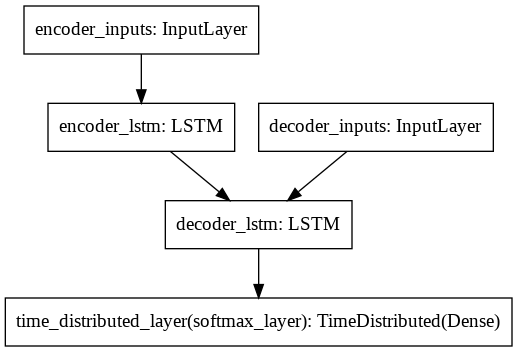

In [15]:
###""" Defining the full model """
full_model_seq2seq_lstm, infer_enc_model_seq2seq_lstm, infer_dec_model_seq2seq_lstm = define_seq2seq_lstm(
    hidden_size=hidden_size,
    batch_size=batch_size,
    enc_timesteps=enc_timesteps,
    dec_timesteps=dec_timesteps,
    enc_vsize=enc_vsize,
    dec_vsize=dec_vsize)
#
plot_model(full_model_seq2seq_lstm)

In [16]:
%%time
loss_seq2seq_lstm, accuracy_seq2seq_lstm = train_seq2seq_lstm(full_model_seq2seq_lstm, enc_seq, dec_seq, batch_size, n_epochs)

Loss/Accuracy in epoch 1: 1.0448111637025816/0.5893510430626719
Loss/Accuracy in epoch 2: 0.680269728528808/0.7241707958726802
Loss/Accuracy in epoch 3: 0.38713238819202467/0.8540756101282234
Loss/Accuracy in epoch 4: 0.13133021018486418/0.9589565544046907
Loss/Accuracy in epoch 5: 0.05107735066098875/0.9853118532403582
CPU times: user 14min 59s, sys: 42 s, total: 15min 41s
Wall time: 9min 7s


### Training: Simple Seq-to-seq (GRU)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(128, 29, 37)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(128, 11, 14)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(128, 256), (128, 2 226560      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(128, 11, 256), (12 208896      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

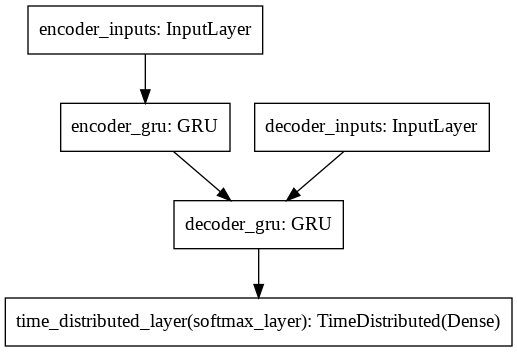

In [17]:
###""" Defining the full model """
full_model_seq2seq, infer_enc_model_seq2seq, infer_dec_model_seq2seq = define_seq2seq(
    hidden_size=hidden_size,
    batch_size=batch_size,
    enc_timesteps=enc_timesteps,
    dec_timesteps=dec_timesteps,
    enc_vsize=enc_vsize,
    dec_vsize=dec_vsize)

plot_model(full_model_seq2seq)

In [18]:
%%time
loss_seq2seq, accuracy_seq2seq = train_seq2seq(full_model_seq2seq, enc_seq, dec_seq, batch_size, n_epochs)

Loss/Accuracy in epoch 1: 1.0695388979381986/0.5765689765965497
Loss/Accuracy in epoch 2: 0.7475275984856478/0.6823786722968447
Loss/Accuracy in epoch 3: 0.5588725376502741/0.7645141300652442
Loss/Accuracy in epoch 4: 0.33850457478962054/0.8598768120138054
Loss/Accuracy in epoch 5: 0.11157934001495695/0.966578850379357
CPU times: user 11min 44s, sys: 33.6 s, total: 12min 18s
Wall time: 7min 10s


In [19]:
# def translate_seq2seq(infer_enc_model, infer_dec_model, test_enc_text, 
#               enc_vsize, dec_vsize, enc_timesteps, dec_timesteps,
#               enc_tokenizer, dec_tokenizer):
#     """ Inferring with trained model """
#     test_enc = test_enc_text
#     print('Translating: {}'.format(test_enc))

#     test_enc_seq = sents2sequences(
#         enc_tokenizer, [test_enc], pad_length=enc_timesteps)

#     test_dec, attn_weights = infer_seq2seq(
#         encoder_model=infer_enc_model, decoder_model=infer_dec_model,
#         test_enc_seq=test_enc_seq, enc_vsize=enc_vsize, dec_vsize=dec_vsize, dec_timesteps = dec_timesteps)
#     print('\tFrench: {}'.format(test_dec))
#     return test_enc_seq, test_dec, attn_weights

### Training: Seq-to-seq Bidirectional

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(128, 29, 37)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(128, 512), (128, 2 453120      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(128, 11, 14)]      0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (128, 512)           0           bidirectional[0][1]              
                                                                 bidirectional[0][2]        

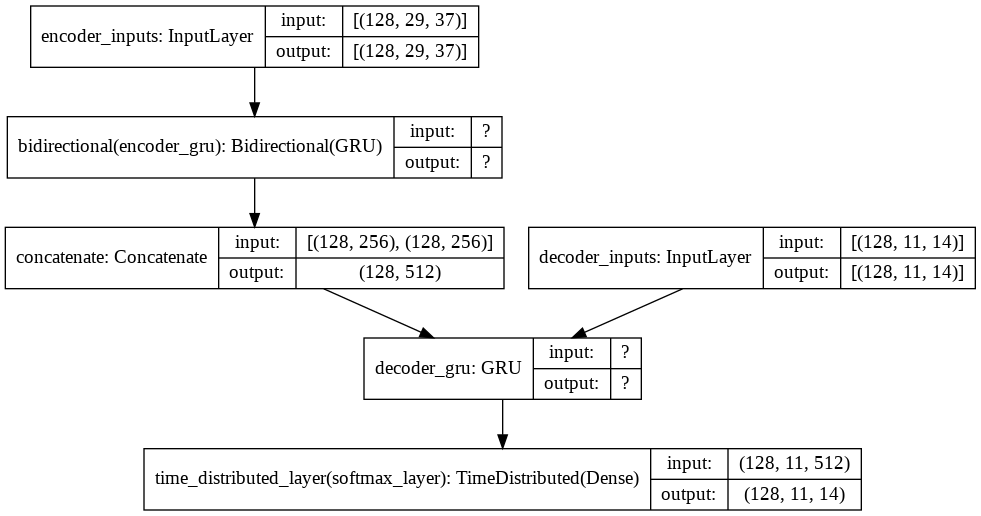

In [20]:
##""" Defining the full model """
full_model_biseq2seq, infer_enc_model_biseq2seq, infer_dec_model_biseq2seq = define_biseq2seq(
    hidden_size=hidden_size,
    batch_size=batch_size,
    enc_timesteps=enc_timesteps,
    dec_timesteps=dec_timesteps,
    enc_vsize=enc_vsize,
    dec_vsize=dec_vsize)

plot_model(full_model_biseq2seq, show_shapes=True)

In [21]:
%%time
loss_biseq2seq, accuracy_biseq2seq = train_biseq2seq(full_model_biseq2seq, enc_seq, dec_seq, batch_size, n_epochs)

Loss/Accuracy in epoch 1: 1.0059230023639494/0.5991829345878373
Loss/Accuracy in epoch 2: 0.4645554677628384/0.8282423591681695
Loss/Accuracy in epoch 3: 0.056976683780105196/0.986726235460352
Loss/Accuracy in epoch 4: 0.0030320631018428508/0.9999656009877849
Loss/Accuracy in epoch 5: 0.0011734639584986318/0.9999878593319841
CPU times: user 25min 52s, sys: 1min 5s, total: 26min 58s
Wall time: 14min 44s


### Training: Seq-to-Seq Peeky Bidirectional 

- Codes do not work yet.

In [22]:
# ##""" Defining the full model """
# full_model_peekybiseq2seq, infer_enc_model_peekybiseq2seq, infer_dec_model_peekybiseq2seq = define_peekybiseq2seq(
#     hidden_size=hidden_size,
#     batch_size=batch_size,
#     enc_timesteps=enc_timesteps,
#     dec_timesteps=dec_timesteps,
#     enc_vsize=enc_vsize,
#     dec_vsize=dec_vsize)

# plot_model(full_model_peekybiseq2seq, show_shapes=True)

### Training: Seq-to-seq with Attention

In [23]:
###""" Defining the full model """
full_model, infer_enc_model, infer_dec_model = define_nmt(
    hidden_size=hidden_size,
    batch_size=batch_size,
    enc_timesteps=enc_timesteps,
    dec_timesteps=dec_timesteps,
    enc_vsize=enc_vsize,
    dec_vsize=dec_vsize)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(128, 29, 37)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(128, 11, 14)]      0                                            
__________________________________________________________________________________________________
encoder_gru (GRU)               [(128, 29, 256), (12 226560      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_gru (GRU)               [(128, 11, 256), (12 208896      decoder_inputs[0][0]             
                                                                 encoder_gru[0][1]          

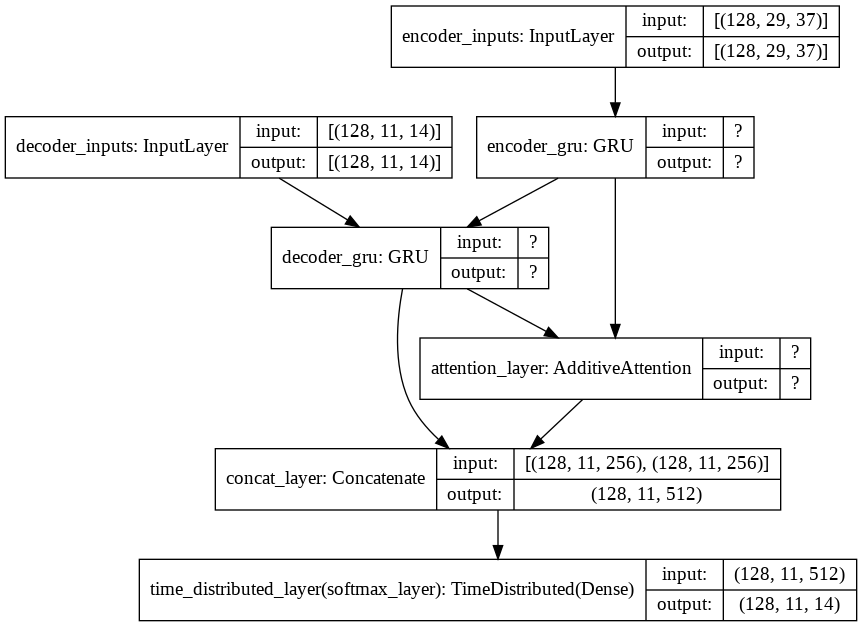

In [24]:

plot_model(full_model, show_shapes=True)

In [25]:
%%time
loss, accuracy = train(full_model, enc_seq, dec_seq, batch_size, n_epochs)

Loss/Accuracy in epoch 1: 0.8815322644010908/0.6790035761404581
Loss/Accuracy in epoch 2: 0.12183195471954651/0.9663785283382123
Loss/Accuracy in epoch 3: 0.016892583125358462/0.9977661194624724
Loss/Accuracy in epoch 4: 0.004128781098214395/0.9998704977864213
Loss/Accuracy in epoch 5: 0.019457585401196256/0.9960927363814112
CPU times: user 18min 13s, sys: 43.9 s, total: 18min 57s
Wall time: 10min 41s


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


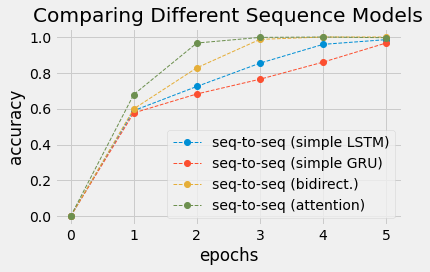

In [26]:
plt.style.use('fivethirtyeight')
plt.plot(range(len(accuracy_seq2seq_lstm)+1), [0]+accuracy_seq2seq_lstm,linestyle='--', marker='o', linewidth=1, label='seq-to-seq (simple LSTM)')

plt.plot(range(len(accuracy_seq2seq)+1), [0]+ accuracy_seq2seq, linestyle='--', marker='o', linewidth=1, label='seq-to-seq (simple GRU)')
plt.plot(range(len(accuracy_biseq2seq)+1), [0]+accuracy_biseq2seq,linestyle='--', marker='o', linewidth=1, label='seq-to-seq (bidirect.)')
plt.plot(range(len(accuracy[:5])+1), [0]+accuracy[:5], linestyle='--', marker='o', linewidth=1, label='seq-to-seq (attention)')
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

### Model Saving

In [27]:
# full_model.save('../../../RepositoryData/output/seq2seq-attention-addition/full-model.h5')
# infer_enc_model.save('../../../RepositoryData/output/seq2seq-attention-addition/infer-enc-model.h5')
# infer_dec_model.save('../../../RepositoryData/output/seq2seq-attention-addition/infer-dec-model.h5')


full_model.save('../../../RepositoryData/output/seq2seq-attention-addition/full-model.h5')
infer_enc_model.save('../../../RepositoryData/output/seq2seq-attention-addition/infer-enc-model.h5')
infer_dec_model.save('../../../RepositoryData/output/seq2seq-attention-addition/infer-dec-model.h5')

### Prediction

In [28]:
# full_model.load_weights('../../../RepositoryData/output/seq2seq-attention-addition/full-model.h5')
# infer_enc_model.load_weights('../../../RepositoryData/output/seq2seq-attention-addition/infer-enc-model.h5')
# infer_dec_model.load_weights('../../../RepositoryData/output/seq2seq-attention-addition/infer-dec-model.h5')

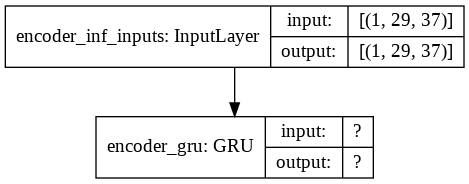

In [29]:
plot_model(infer_enc_model,show_shapes=True)

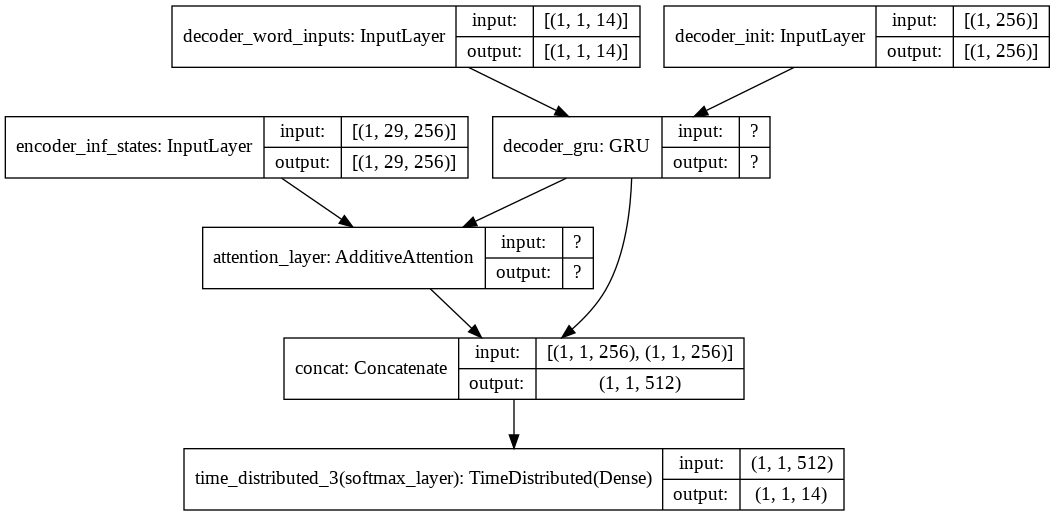

In [30]:
plot_model(infer_dec_model, show_shapes=True)

In [31]:
def translate(infer_enc_model, infer_dec_model, test_enc_text, 
              enc_vsize, dec_vsize, enc_timesteps, dec_timesteps,
              enc_tokenizer, dec_tokenizer):
    """ Inferring with trained model """
    test_enc = test_enc_text
    print('Translating: {}'.format(test_enc))

    test_enc_seq = sents2sequences(
        enc_tokenizer, [test_enc], pad_length=enc_timesteps)

    test_dec, attn_weights = infer_nmt(
        encoder_model=infer_enc_model, decoder_model=infer_dec_model,
        test_enc_seq=test_enc_seq, enc_vsize=enc_vsize, dec_vsize=dec_vsize, dec_timesteps = dec_timesteps)
    print('\tFrench: {}'.format(test_dec))
    return test_enc_seq, test_dec, attn_weights

In [32]:
test_enc_seq, test_dec, attn_weights=translate(infer_enc_model=infer_enc_model,
          infer_dec_model=infer_dec_model,
          test_enc_text=ts_enc_text[120],
          enc_vsize=enc_vsize,
          dec_vsize=dec_vsize,
          enc_timesteps=enc_timesteps,
          dec_timesteps=dec_timesteps,
          enc_tokenizer=enc_tokenizer,
          dec_tokenizer=dec_tokenizer)



Translating: Sep 14, 1999                 
	French: 1999-09-14__


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


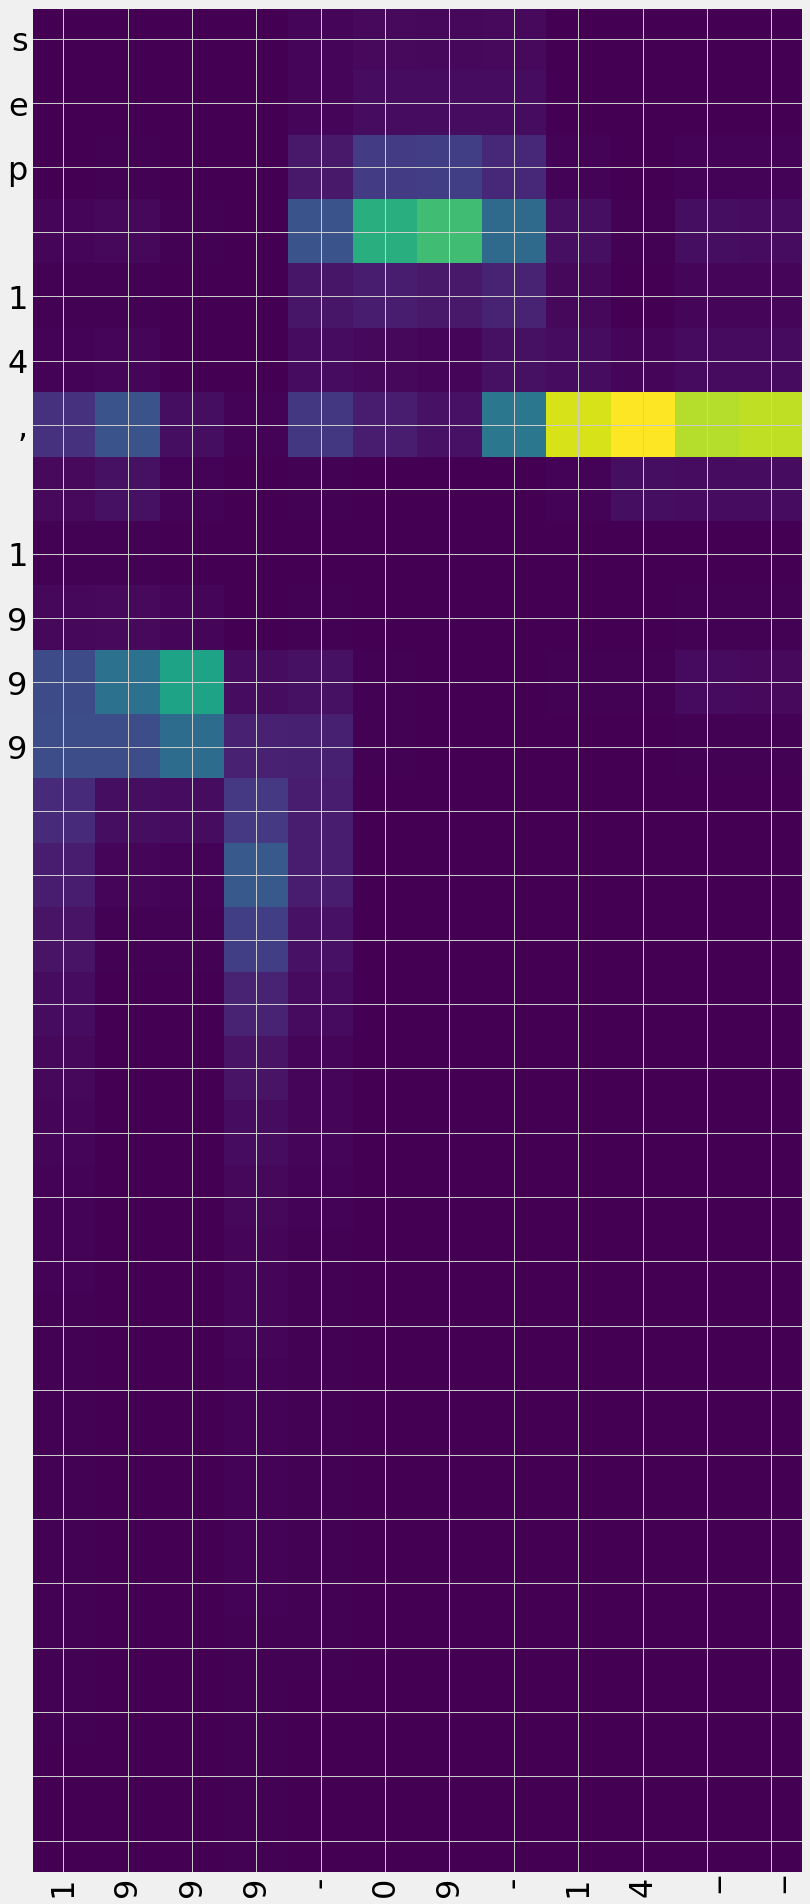

In [33]:
""" Attention plotting """
plot_attention_weights(test_enc_seq, attn_weights,
                       enc_index2word, dec_index2word)

In [34]:

print(tr_enc_text[:5])
print(tr_dec_text[:5])



['June 16, 2015                ', '12/16/83                     ', 'SEPTEMBER 9, 1998            ', 'April 17, 2013               ', 'January 26, 1990             ']
['_2015-06-16_', '_1983-12-16_', '_1998-09-09_', '_2013-04-17_', '_1990-01-26_']


## Evaluation on Test Data

In [35]:
%%time

def test(full_model, ts_enc_text, ts_dec_text, enc_tokenizer, dec_tokenizer, batch_size):
    # ### Getting sequence integer data
    ts_enc_seq, ts_dec_seq = preprocess_data(enc_tokenizer, dec_tokenizer, ts_enc_text, ts_dec_text)
    losses = []
    accuracies = []
    for bi in range(0, ts_enc_seq.shape[0] - batch_size, batch_size):
        enc_onehot_seq = to_categorical(
            ts_enc_seq[bi:bi + batch_size, :], num_classes=enc_vsize)
        dec_onehot_seq = to_categorical(
            ts_dec_seq[bi:bi + batch_size, :], num_classes=dec_vsize)

        # full_model.train_on_batch(
        #     [enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :])
        l,a = full_model.evaluate([enc_onehot_seq, dec_onehot_seq[:, :-1, :]], dec_onehot_seq[:, 1:, :],
                                batch_size=batch_size, verbose=0)
        losses.append(l)
        accuracies.append(a)
    print('Average Loss:{}'.format(np.mean(losses)))
    print('Average Accuracy:{}'.format(np.mean(accuracies)))

test(full_model, ts_enc_text = ts_enc_text, ts_dec_text = ts_dec_text, 
     enc_tokenizer = enc_tokenizer, dec_tokenizer = dec_tokenizer, batch_size = batch_size)

Average Loss:0.003032323147470073
Average Accuracy:0.9999271548032082
CPU times: user 1min 4s, sys: 2.43 s, total: 1min 7s
Wall time: 42.8 s
